# Données multidimensionnelles SQL - énoncé

Ce notebook propose l'utilisation de SQL avec [SQLite](https://sqlite.org/) pour manipuler les données depuis un notebook (avec le module [sqlite3](https://docs.python.org/3.6/library/sqlite3.html)).

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pyensae
from pyquickhelper.helpgen import NbImage
from jyquickhelper import add_notebook_menu
add_notebook_menu()

Populating the interactive namespace from numpy and matplotlib


### Représentation

Le module [pandas](http://pandas.pydata.org/) manipule des tables et c'est la façon la plus commune de représenter les données. Lorsque les données sont multidimensionnelles, on distingue les coordonnées des valeurs :

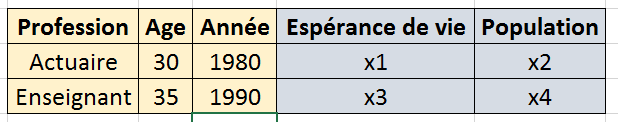

In [ ]:
NbImage("cube1.png")

Dans cet exemple, il y a :
    
* 3 coordonnées : Age, Profession, Annéee
* 2 valeurs : Espérance de vie, Population

On peut représenter les donnés également comme ceci :

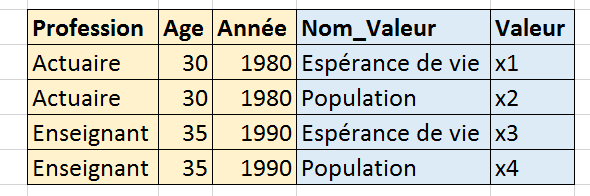

In [ ]:
NbImage("cube2.png")

C'est assez simple. Prenons un exemple : [table de mortalité de 1960 à 2010](http://www.data-publica.com/opendata/7098--population-et-conditions-sociales-table-de-mortalite-de-1960-a-2010) qu'on récupère à l'aide de la fonction [table_mortalite_euro_stat](http://www.xavierdupre.fr/app/actuariat_python/helpsphinx/actuariat_python/data/population.html#actuariat_python.data.population.table_mortalite_euro_stat). C'est assez long (4-5 minutes) sur l'ensemble des données car elles doivent être prétraitées (voir la documentation de la fonction). Pour écouter, il faut utiliser le paramètre *stop_at*.

In [ ]:
from actuariat_python.data import table_mortalite_euro_stat 
table_mortalite_euro_stat()

'mortalite.txt'

In [ ]:
import os
os.stat("mortalite.txt")

os.stat_result(st_mode=33206, st_ino=4222124650782732, st_dev=2797837379, st_nlink=1, st_uid=0, st_gid=0, st_size=105075819, st_atime=1453573270, st_mtime=1453573285, st_ctime=1453573270)

In [ ]:
import pandas
df = pandas.read_csv("mortalite.txt", sep="\t", encoding="utf8", low_memory=False)
df.head()

,annee,valeur,age,age_num,indicateur,genre,pays
0,2009,0.00080,Y01,1,DEATHRATE,F,AM
1,2008,0.00067,Y01,1,DEATHRATE,F,AM
2,2007,0.00052,Y01,1,DEATHRATE,F,AM
3,2006,0.00123,Y01,1,DEATHRATE,F,AM
4,2013,0.00016,Y01,1,DEATHRATE,F,AT


Les indicateurs pour deux âges différents :

In [ ]:
df [ ((df.age=="Y60") | (df.age=="Y61")) & (df.annee == 2000) & (df.pays=="FR") & (df.genre=="F")]

,annee,valeur,age,age_num,indicateur,genre,pays
86895,2000,0.00502,Y60,60,DEATHRATE,F,FR
88435,2000,0.00486,Y61,61,DEATHRATE,F,FR
482573,2000,25.80000,Y60,60,LIFEXP,F,FR
484098,2000,24.90000,Y61,61,LIFEXP,F,FR
876261,2000,0.00501,Y60,60,PROBDEATH,F,FR
877801,2000,0.00485,Y61,61,PROBDEATH,F,FR
1272615,2000,0.99499,Y60,60,PROBSURV,F,FR
1274155,2000,0.99515,Y61,61,PROBSURV,F,FR
1668215,2000,93076.00000,Y60,60,PYLIVED,F,FR
1669740,2000,92618.00000,Y61,61,PYLIVED,F,FR


### Exercice 1 : filtre

On veut comparer les espérances de vie pour deux pays et deux années.

In [ ]:
#

### Données trop grosses pour tenir en mémoire : SQLite


In [ ]:
df.shape

(2760921, 7)

Les données sont trop grosses pour tenir dans une feuille Excel. Pour les consulter, il n'y a pas d'autres moyens que d'en regarder des extraits. Que passe quand même ceci n'est pas possible ? Quelques solutions :

* augmenter la mémoire de l'ordinateur, avec 20 Go, on peut faire beaucoup de choses
* stocker les données dans un serveur SQL
* stocker les données sur un système distribué (cloud, Hadoop, ...)

La seconde option n'est pas toujours simple, il faut installer un serveur SQL. Pour aller plus vite, on peut simplement utiliser [SQLite](https://www.sqlite.org/) qui est une façon de faire du SQL sans serveur (cela prend quelques minutes). On utilise la méthode [to_sql](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_sql.html).

In [ ]:
import sqlite3
from pandas.io import sql
cnx = sqlite3.connect('mortalite.db3')
try:
    df.to_sql(name='mortalite', con=cnx)
except ValueError as e:
    if "Table 'mortalite' already exists" not in str(e):
        # seulement si l'erreur ne vient pas du fait que cela 
        # a déjà été fait
        raise e
# on peut ajouter d'autres dataframe à la table comme si elle était créée par morceau
# voir le paramètre if_exists de la fonction to_sql

On peut maintenant récupérer un morceau avec la fonction [read_sql](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql.html?highlight=read_sql#pandas.read_sql).

In [ ]:
import pandas
example = pandas.read_sql('select * from mortalite where age_num==50 limit 5', cnx)
example

,index,annee,valeur,age,age_num,indicateur,genre,pays
0,69225,2009,0.00290,Y50,50,DEATHRATE,F,AM
1,69226,2008,0.00333,Y50,50,DEATHRATE,F,AM
2,69227,2007,0.00292,Y50,50,DEATHRATE,F,AM
3,69228,2006,0.00371,Y50,50,DEATHRATE,F,AM
4,69229,2013,0.00194,Y50,50,DEATHRATE,F,AT


L'ensemble des données restent sur le disque, seul le résultat de la requête est chargé en mémoire. Si on ne peut pas faire tenir les données en mémoire, il faut soit en obtenir une vue partielle (un échantillon aléatoire, un vue filtrée), soit une vue agrégrée.

Pour finir, il faut fermer la connexion pour laisser d'autres applications ou notebook modifier la base ou tout simplement supprimer le fichier.

In [ ]:
cnx.close()

Sous Windows, on peut consulter la base avec le logiciel [SQLiteSpy](http://www.yunqa.de/delphi/doku.php/products/sqlitespy/index).

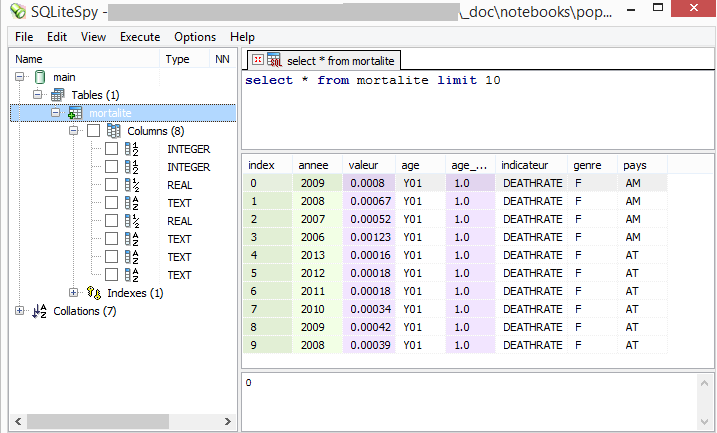

In [ ]:
NbImage("sqlite.png")

Sous Linux ou Max, on peut utiliser une extension Firefox [SQLite Manager](https://addons.mozilla.org/en-US/firefox/addon/sqlite-manager/?src). Dans ce notebook, on utilisera la commande magique [%%SQL](http://www.xavierdupre.fr/app/pyensae/helpsphinx/notebooks/pyensae_sql_magic.html) du module [pyensae](http://www.xavierdupre.fr/app/pyensae/helpsphinx/) : 

In [ ]:
%load_ext pyensae
%SQL_connect mortalite.db3

In [ ]:
%SQL_tables

['mortalite']

In [ ]:
%SQL_schema mortalite

{0: ('index', int),
 1: ('annee', int),
 2: ('valeur', float),
 3: ('age', str),
 4: ('age_num', float),
 5: ('indicateur', str),
 6: ('genre', str),
 7: ('pays', str)}

In [ ]:
%%SQL
SELECT COUNT(*) FROM mortalite

,COUNT(*)
0,2760921


In [ ]:
%SQL_close

### Exercice 2 : échantillon aléatoire

Si on ne peut pas faire tenir les données en mémoire, on peut soit regarder les premières lignes soit prendre un échantillon aléatoire. Deux options :

* [Dataframe.sample](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html)
* [create_function](https://docs.python.org/3.4/library/sqlite3.html#sqlite3.Connection.create_function)

La première fonction est simple :

In [ ]:
sample = df.sample(frac=0.1)
sample.shape, df.shape

((276092, 7), (2760921, 7))

Je ne sais pas si cela peut être réalisé sans charger les données en mémoire. Si les données pèsent 20 Go, cette méthode n'aboutira pas. Pourtant, on veut juste un échantillon pour commencer à regarder les données. On utilise la seconde option avec [create_function](https://docs.python.org/3.4/library/sqlite3.html#sqlite3.Connection.create_function) et la fonction suivante :

In [ ]:
import random  #loi uniforme
def echantillon(proportion):
    return 1 if random.random() < proportion else 0

In [ ]:
import sqlite3
from pandas.io import sql
cnx = sqlite3.connect('mortalite.db3')

In [ ]:
cnx.create_function('echantillon', 1, echantillon)

Que faut-il écrire ici pour récupérer 1% de la table ?

In [ ]:
import pandas
#example = pandas.read_sql(' ???  ', cnx)
#example

In [ ]:
cnx.close()

### Pseudo Map/Reduce avec SQLite

La liste des [mots-clés du langage SQL utilisés par SQLite](https://www.sqlite.org/keyword_index.html) n'est pas aussi riche que d'autres solutions de serveurs SQL. La médiane ne semble pas en faire partie. Cependant, pour une année, un genre, un âge donné, on voudrait calculer la médiane de l'espérance de vie sur l'ensembles des pays.

In [ ]:
import sqlite3, pandas
from pandas.io import sql
cnx = sqlite3.connect('mortalite.db3')

In [ ]:
pandas.read_sql('select pays,count(*) from mortalite group by pays', cnx)

,pays,count(*)
0,AM,7224
1,AT,79464
2,AZ,12642
3,BE,97524
4,BG,97524
5,BY,5418
6,CH,97524
7,CY,37926
8,CZ,97524
9,DE,52374


Il n'y a pas le même nombre de données selon les pays, il est probable que le nombre de pays pour lesquels il existe des données varie selon les âges et les années.

In [ ]:
query = """SELECT nb_country, COUNT(*) AS nb_rows FROM (
                SELECT annee,age,age_num, count(*) AS nb_country FROM mortalite 
                WHERE indicateur=="LIFEXP" AND genre=="F"
                GROUP BY annee,age,age_num
            ) GROUP BY nb_country"""
df = pandas.read_sql(query, cnx)

In [ ]:
df.sort_values("nb_country", ascending=False).head(n=2)

,nb_country,nb_rows
37,104,5
36,102,2


In [ ]:
df.plot(x="nb_country", y="nb_rows")

Soit un nombre inconstant de pays. Le fait qu'on est 100 pays suggère qu'on ait une erreur également.

In [ ]:
query = """SELECT annee,age,age_num, count(*) AS nb_country FROM mortalite 
                WHERE indicateur=="LIFEXP" AND genre=="F"
                GROUP BY annee,age,age_num
                HAVING nb_country >= 100"""
df = pandas.read_sql(query, cnx)

In [ ]:
df.head()

,annee,age,age_num,nb_country
0,2006,None,None,104
1,2007,None,None,104
2,2008,None,None,104
3,2009,None,None,104
4,2010,None,None,104


Ce sont des valeurs manquantes. Le problème pour calculer la médiane pour chaque observation est qu'il faut d'abord regrouper les lignes de la table par indicateur puis choisir la médiane dans chaque de ces petits groupes. On s'inspire pour cela de la logique Map/Reduce et de la fonction [create_aggregate](https://docs.python.org/3.4/library/sqlite3.html#sqlite3.Connection.create_aggregate).

### Exercice 3 : reducer SQL

Il faut compléter le programme suivant.

In [ ]:
class ReducerMediane:
    def __init__(self):
        # ???
        pass
    def step(self, value):
        # ???
        #
        pass
    def finalize(self):
        # ???
        # return ... //2 ]
        pass
    
cnx.create_aggregate("ReducerMediane", 1, ReducerMediane)    

In [ ]:
#query = """SELECT annee,age,age_num, ...... AS mediane FROM mortalite 
#                WHERE indicateur=="LIFEXP" AND genre=="F"
#                GROUP BY annee,age,age_num"""
#df = pandas.read_sql(query, cnx)

In [ ]:
cnx.close()

### Notion d'index

En SQL et pour de grandes tables, la notion d'index joue un rôle important pour accélérer les opérations de jointures (``JOIN``) ou de regroupement (``GROUP BY``). L'article [A thorough guide to SQLite database operations in Python](http://sebastianraschka.com/Articles/2014_sqlite_in_python_tutorial.html) montre comment faire les principales opérations.